In [15]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve

In [2]:
df = pd.read_csv("../Data/flight_dep_classi_tree.csv")
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45155 entries, 0 to 45154
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   MONTH                      45155 non-null  int64  
 1   DAY_OF_MONTH               45155 non-null  int64  
 2   DAY_OF_WEEK                45155 non-null  int64  
 3   CRS_DEP_TIME               45155 non-null  float64
 4   CRS_ELAPSED_TIME           45155 non-null  float64
 5   OP_UNIQUE_CARRIER          45155 non-null  int64  
 6   ORIGIN                     45155 non-null  int64  
 7   DEST                       45155 non-null  int64  
 8   DISTANCE                   45155 non-null  float64
 9   HourlyDewPointTemperature  45155 non-null  float64
 10  HourlyDryBulbTemperature   45155 non-null  float64
 11  HourlyRelativeHumidity     45155 non-null  float64
 12  HourlyVisibility           45155 non-null  float64
 13  HourlyWindSpeed            45155 non-null  flo

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,CRS_ELAPSED_TIME,OP_UNIQUE_CARRIER,ORIGIN,DEST,DISTANCE,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyVisibility,HourlyWindSpeed,DEP_DEL15
count,45155.000000,45155.000000,45155.000000,45155.000000,45155.000000,45155.000000,45155.000000,45155.000000,45155.000000,45155.000000,45155.000000,45155.000000,45155.000000,45155.000000,45155.000000
mean,5.046728,15.877489,3.971321,13.585353,183.310597,4.342642,3.611007,45.445288,1175.492703,42.800066,59.471664,57.692747,9.810818,8.246529,0.117418
std,0.808438,8.780866,2.005020,5.287004,84.569100,3.858876,0.992802,25.759279,732.185970,6.723190,9.337098,18.536586,0.983229,3.873726,0.321921
min,4.000000,1.000000,1.000000,0.080000,49.000000,0.000000,0.000000,0.000000,93.000000,5.000000,30.000000,11.000000,0.000000,0.000000,0.000000
25%,4.000000,8.000000,2.000000,9.080000,125.000000,1.000000,4.000000,22.000000,679.000000,39.000000,53.000000,44.000000,10.000000,6.000000,0.000000
50%,5.000000,16.000000,4.000000,12.970000,166.000000,3.000000,4.000000,45.000000,978.000000,43.000000,58.000000,59.000000,10.000000,8.000000,0.000000
75%,6.000000,23.000000,6.000000,17.900000,244.000000,9.000000,4.000000,71.000000,1721.000000,48.000000,65.000000,71.000000,10.000000,10.000000,0.000000
max,6.000000,31.000000,7.000000,23.980000,411.000000,11.000000,4.000000,85.000000,2724.000000,60.000000,102.000000,100.000000,10.000000,30.000000,1.000000


In [3]:
X = df.drop(columns=["DEP_DEL15"])
y = df["DEP_DEL15"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
print(y_train.value_counts(normalize=True))

Training set: (36124, 14), Test set: (9031, 14)
DEP_DEL15
0.0    0.882571
1.0    0.117429
Name: proportion, dtype: float64


In [5]:
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  
)

In [6]:
param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

In [7]:
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2
)

start = time.time()
grid.fit(X_train, y_train)
end = time.time()

print(f" Time: {end - start:.2f} s")
print(" Best Parameters:", grid.best_params_)
print(f" Best CV ROC-AUC: {grid.best_score_:.4f}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
 Time: 263.58 s
 Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 400}
 Best CV ROC-AUC: 0.7017


In [22]:
best_rf = grid.best_estimator_

y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)

print("\n Random Forest Classifier")
print(f"Accuracy : {acc:.4f}")
print(f"Precision (delay=1) : {prec:.4f}")
print(f"Recall (delay=1)    : {rec:.4f}")
print(f"F1-score (delay=1)  : {f1:.4f}")
print(f"ROC-AUC             : {roc:.4f}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred, digits=4))


 Random Forest Classifier
Accuracy : 0.6840
Precision (delay=1) : 0.2145
Recall (delay=1)    : 0.6358
F1-score (delay=1)  : 0.3208
ROC-AUC             : 0.7198

 Classification Report:
              precision    recall  f1-score   support

         0.0     0.9345    0.6904    0.7941      7971
         1.0     0.2145    0.6358    0.3208      1060

    accuracy                         0.6840      9031
   macro avg     0.5745    0.6631    0.5574      9031
weighted avg     0.8500    0.6840    0.7385      9031




 Threshold Optimization
Best Threshold: 0.522
Precision: 0.226
Recall:    0.579
F1-score:  0.325


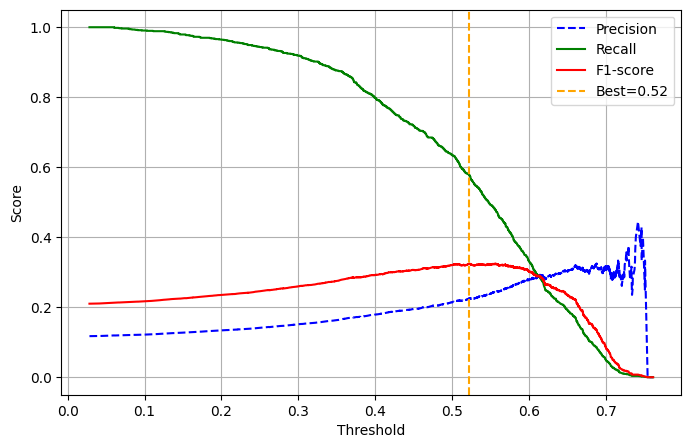

In [23]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]

print("\n Threshold Optimization")
print(f"Best Threshold: {best_thresh:.3f}")
print(f"Precision: {precisions[best_idx]:.3f}")
print(f"Recall:    {recalls[best_idx]:.3f}")
print(f"F1-score:  {f1_scores[best_idx]:.3f}")

# Precision–Recall vs Threshold
plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.plot(thresholds, f1_scores[:-1], 'r-', label='F1-score')
plt.axvline(x=best_thresh, color='orange', linestyle='--', label=f'Best={best_thresh:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
y_pred_best = (y_prob >= best_thresh).astype(int)

acc2 = accuracy_score(y_test, y_pred_best)
prec2 = precision_score(y_test, y_pred_best)
rec2 = recall_score(y_test, y_pred_best)
f12 = f1_score(y_test, y_pred_best)
roc2 = roc_auc_score(y_test, y_prob)

print("\n Re-evaluate with Optimized Threshold")
print(f"Accuracy : {acc2:.4f}")
print(f"Precision (delay=1) : {prec2:.4f}")
print(f"Recall (delay=1)    : {rec2:.4f}")
print(f"F1-score (delay=1)  : {f12:.4f}")
print(f"ROC-AUC             : {roc2:.4f}")

print("\n Updated Classification Report:")
print(classification_report(y_test, y_pred_best, digits=4))


 Re-evaluate with Optimized Threshold
Accuracy : 0.7172
Precision (delay=1) : 0.2256
Recall (delay=1)    : 0.5792
F1-score (delay=1)  : 0.3247
ROC-AUC             : 0.7198

 Updated Classification Report:
              precision    recall  f1-score   support

         0.0     0.9293    0.7355    0.8211      7971
         1.0     0.2256    0.5792    0.3247      1060

    accuracy                         0.7172      9031
   macro avg     0.5774    0.6574    0.5729      9031
weighted avg     0.8467    0.7172    0.7629      9031



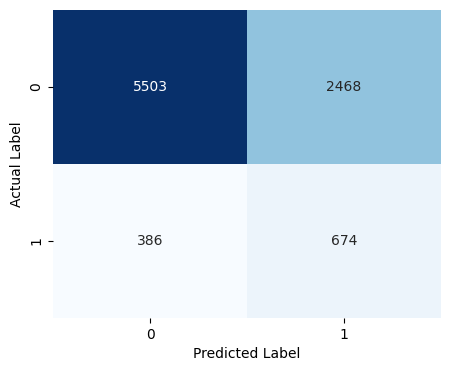

In [21]:
# Confusion Matrix – Random Forest
plt.figure(figsize=(5,4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

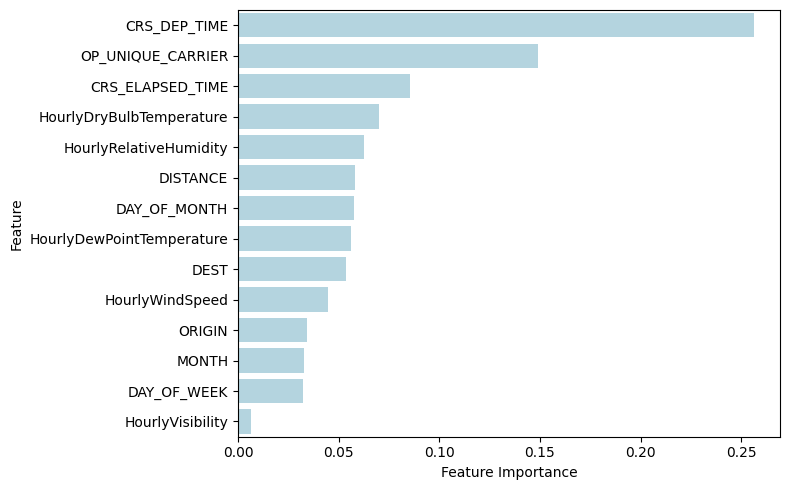

In [14]:
# Top 15 Important Features (Random Forest)
importances = best_rf.feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp[:15], y=feat_imp.index[:15], color='lightblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()